In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
from PIL import Image
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
import torch
import numpy as np
import cv2
from PIL import Image
from glob import glob


class Dataset(torch.utils.data.Dataset):
    def __init__(self, transform=None, classes=None, augmentation=None):
        self.imgpath_list = sorted(
            glob('./archive/ISTD_Dataset/train/train_A/*.png'))
        self.labelpath_list = sorted(
            glob('./archive/ISTD_Dataset/train/train_B/*.png'))

    def __getitem__(self, i):
        # Load and process the image
        imgpath = self.imgpath_list[i]
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize=(256, 256))
        img = img / 255
        img = torch.from_numpy(img.astype(np.float32)).clone()
        img = img.permute(2, 0, 1)

        # Load and process the label
        labelpath = self.labelpath_list[i]
        label = Image.open(labelpath)
        label = np.asarray(label)
        label = cv2.resize(label, dsize=(256, 256))

        # Ensure label values are either 0 or 1
        label[label != 0] = 1

        # Convert label to PyTorch tensor
        label = torch.from_numpy(label.astype(np.float32)).clone()

        data = {"img": img, "label": label}
        return data

    def __len__(self):
        return len(self.imgpath_list)

In [3]:
dataset = Dataset()

In [4]:
len(dataset)

1330

In [5]:
train, val, test = torch.utils.data.random_split(dataset=dataset, lengths=[
                                                 1000, 100, 230], generator=torch.Generator().manual_seed(42))

In [6]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


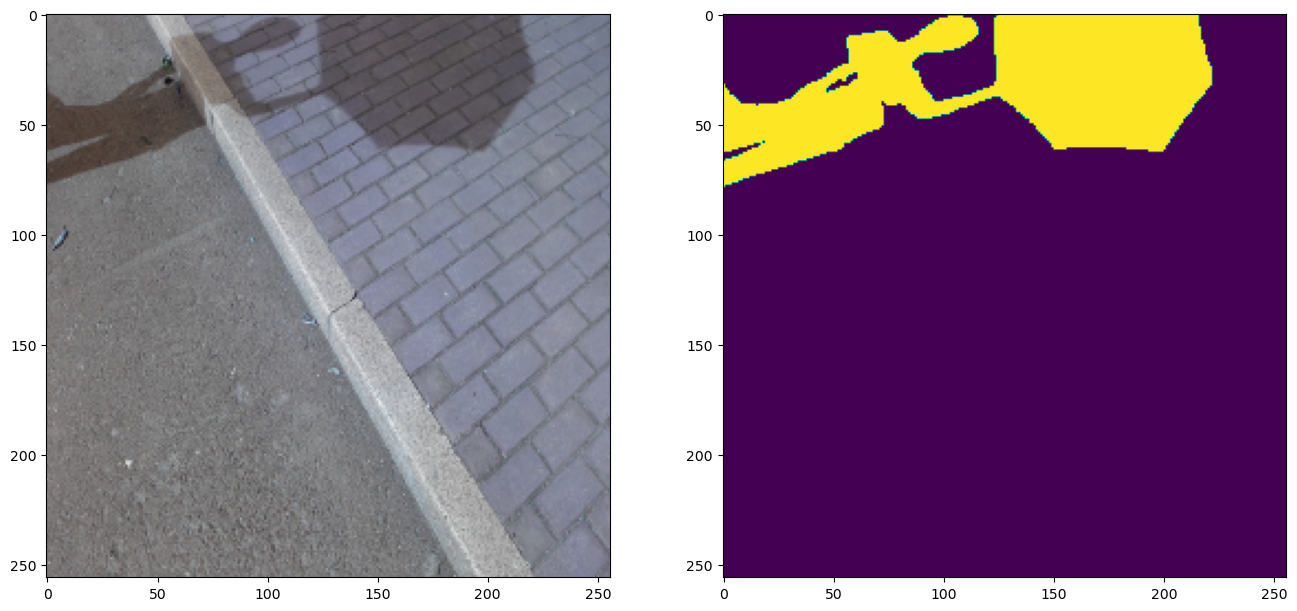

In [7]:
# visualize
dataiter = iter(train_loader)
data = next(dataiter)
img = data['img']
label = data['label']
print(img.shape)
print(label.shape)
# plot
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(122)
plt.imshow(label[0])
plt.show()

In [8]:
import torch
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder_conv1 = self.conv_block(in_channels, 64)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_conv2 = self.conv_block(64, 128)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_conv3 = self.conv_block(128, 256)
        self.encoder_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_conv4 = self.conv_block(256, 512)
        self.encoder_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv = self.conv_block(512, 1024)

        # Decoder
        self.decoder_upconv4 = nn.ConvTranspose2d(
            1024, 512, kernel_size=2, stride=2)
        self.decoder_conv4 = self.conv_block(1024, 512)
        self.decoder_upconv3 = nn.ConvTranspose2d(
            512, 256, kernel_size=2, stride=2)
        self.decoder_conv3 = self.conv_block(512, 256)
        self.decoder_upconv2 = nn.ConvTranspose2d(
            256, 128, kernel_size=2, stride=2)
        self.decoder_conv2 = self.conv_block(256, 128)
        self.decoder_upconv1 = nn.ConvTranspose2d(
            128, 64, kernel_size=2, stride=2)
        self.decoder_conv1 = self.conv_block(128, 64)

        # Output layer
        # self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        # Encoder
        encoder1 = self.encoder_conv1(x)
        encoder2 = self.encoder_conv2(self.encoder_pool1(encoder1))
        encoder3 = self.encoder_conv3(self.encoder_pool2(encoder2))
        encoder4 = self.encoder_conv4(self.encoder_pool3(encoder3))

        # Bottleneck
        bottleneck = self.bottleneck_conv(self.encoder_pool4(encoder4))

        # Decoder
        decoder4 = self.decoder_upconv4(bottleneck)
        decoder4 = torch.cat((encoder4, decoder4), dim=1)
        decoder4 = self.decoder_conv4(decoder4)
        decoder3 = self.decoder_upconv3(decoder4)
        decoder3 = torch.cat((encoder3, decoder3), dim=1)
        decoder3 = self.decoder_conv3(decoder3)
        decoder2 = self.decoder_upconv2(decoder3)
        decoder2 = torch.cat((encoder2, decoder2), dim=1)
        decoder2 = self.decoder_conv2(decoder2)
        decoder1 = self.decoder_upconv1(decoder2)
        decoder1 = torch.cat((encoder1, decoder1), dim=1)
        decoder1 = self.decoder_conv1(decoder1)

        # Output layer
        output = self.output_conv(decoder1)

        return output

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

In [9]:
import torch
import torch.nn as nn


# Create an instance of the UNet model
in_channels = 3  # Number of input channels (e.g., RGB image)
out_channels = 2  # Number of output channels (e.g., number of classes)
unet_model = UNet(in_channels, out_channels)


# Print the model architecture
print(unet_model)

# Move the model to the device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001)

UNet(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [12]:
num_epochs = 8
best_loss = float('inf')
best_model_state_dict = None

for epoch in range(num_epochs):
    unet_model.train()
    total_loss = 0.0

    for i, sample in enumerate(train_loader):
        inputs = sample['img'].to(device)
        labels = sample['label'].to(device).unsqueeze(1)
        # print(labels)
        optimizer.zero_grad()
        outputs = unet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Val
    unet_model.eval()
    total_val_loss = 0.0

    for i, val_sample in enumerate(val_loader):
        val_inputs = val_sample['img'].to(device)
        val_labels = val_sample['label'].to(device).unsqueeze(1)
        val_outputs = unet_model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {average_val_loss:.4f}")

    # Check if the current model has the best val loss
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        best_model_state_dict = unet_model.state_dict()

# After training, you can use the best model state dict to load the best model
if best_model_state_dict is not None:
    unet_model.load_state_dict(best_model_state_dict)

Epoch [1/4], Batch [10/250], Loss: 0.1151
Epoch [1/4], Batch [20/250], Loss: 0.2204
Epoch [1/4], Batch [30/250], Loss: 0.4656
Epoch [1/4], Batch [40/250], Loss: 0.1319
Epoch [1/4], Batch [50/250], Loss: 0.2737
Epoch [1/4], Batch [60/250], Loss: 0.4983
Epoch [1/4], Batch [70/250], Loss: 0.1980
Epoch [1/4], Batch [80/250], Loss: 0.3169
Epoch [1/4], Batch [90/250], Loss: 0.1188
Epoch [1/4], Batch [100/250], Loss: 0.2305
Epoch [1/4], Batch [110/250], Loss: 0.1333
Epoch [1/4], Batch [120/250], Loss: 0.8686
Epoch [1/4], Batch [130/250], Loss: 0.1908
Epoch [1/4], Batch [140/250], Loss: 0.2312
Epoch [1/4], Batch [150/250], Loss: 0.2716
Epoch [1/4], Batch [160/250], Loss: 0.1119
Epoch [1/4], Batch [170/250], Loss: 0.2428
Epoch [1/4], Batch [180/250], Loss: 0.2124
Epoch [1/4], Batch [190/250], Loss: 0.2551
Epoch [1/4], Batch [200/250], Loss: 0.1412
Epoch [1/4], Batch [210/250], Loss: 0.2399
Epoch [1/4], Batch [220/250], Loss: 0.1502
Epoch [1/4], Batch [230/250], Loss: 0.1998
Epoch [1/4], Batch [

In [12]:
# save model
torch.save(unet_model.state_dict(), './model_state_dict_4.pth')

In [10]:
# #load model
# unet_model.load_state_dict(torch.load('./model_state_dict_15.pth'))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

unet_model.eval()
with torch.no_grad():
    for i, sample in enumerate(test_loader):
        inputs = sample['img'].to(device)
        labels = sample['label'].to(device).unsqueeze(1)

        # Forward pass
        outputs = unet_model(inputs)

        for j in range(inputs.shape[0]):  # Iterate over the batch dimension
            input_image = inputs[j].cpu().numpy()
            output_image = outputs[j].cpu().numpy()
            label_image = labels[j].cpu().numpy()

            # Reshape and plot
            # Reorder dimensions for plotting
            input_image = np.transpose(input_image, (1, 2, 0))
            output_image = output_image.squeeze()  # Remove channel dimension
            label_image = label_image.squeeze()  # Remove channel dimension

            # Convert model output to binary mask
            # Assuming sigmoid activation in the last layer
            output_image = (output_image > 0.5).astype(np.float32)

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(input_image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(output_image, cmap='gray')
            axes[1].set_title('Predicted Mask')
            axes[1].axis('off')

            axes[2].imshow(label_image, cmap='gray')
            axes[2].set_title('Ground Truth')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            if i == 0:  # Optionally, break after the first batch
                break

In [12]:
def calculate_iou(output_image, input_image):
    intersection = np.logical_and(output_image, input_image)
    union = np.logical_or(output_image, input_image)
    iou_score = np.sum(intersection) / np.sum(union)
    print(iou_score)


def calculate_pixel_accuracy(output_image, input_image):
    correct_pixels = np.sum(output_image == input_image)
    total_pixels = output_image.size
    pixel_accuracy = correct_pixels / total_pixels
    print(pixel_accuracy)


def calculate_miou(output_images, input_images):
    miou_scores = []
    for i in range(len(output_images)):
        iou_score = calculate_iou(output_images[i], input_images[i])
        if iou_score is not None:  # Check for None values
            miou_scores.append(iou_score)
    if miou_scores:  # Check if miou_scores is not empty
        miou = np.mean(miou_scores)
        print(miou)
    else:
        print("No valid IoU scores found.")

In [13]:
calculate_iou(output_image, label_image)
print("*"*50)
calculate_pixel_accuracy(output_image, label_image)
print("*"*50)

NameError: name 'output_image' is not defined

In [13]:
import torch
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt


def predict_single_image(image_path, model, device):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, dsize=(256, 256))
    img = img / 255.0  # Normalize pixel values
    img = img.astype(np.float32)
    img = np.transpose(img, (2, 0, 1))  # Change channel order
    img_tensor = torch.from_numpy(img).unsqueeze(0).to(
        device)  # Add batch dimension and send to device

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)

    # Convert output to binary mask
    output_mask = output.squeeze().cpu().numpy()
    # Assuming sigmoid activation in the last layer
    output_mask = (output_mask > 0.5).astype(np.uint8) * \
        255  # Convert to binary mask (0 or 255)

    return output_mask


def process_folder(source_folder, target_folder, model, device):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for image_file in os.listdir(source_folder):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(source_folder, image_file)
            mask = predict_single_image(image_path, model, device)
            mask_image = Image.fromarray(mask)
            # Save mask image with the same name
            mask_image.save(os.path.join(target_folder, image_file))


# Example usage
# Path to folder with images
source_folder = 'Useless Files/cropped_images_3138b71680'
# Path to folder where masks will be saved
target_folder = './predicted_masks_4'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model  # Assuming the model is defined and loaded
unet_model.to(device)
process_folder(source_folder, target_folder, unet_model, device)